In [1]:
import pandas as pd
import requests 
import time
import datetime as dt
import regex as re

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

In [2]:
# Read in data and drop 'unnamed: 0' column
df = pd.read_csv('./communism_socialism.csv').drop(columns='Unnamed: 0')

## <font color = orchid> Clean & Pre-Process Text </font>

In [3]:
# Drop rows with empty title
df = df[df['title'] != '']

# Fill '[removed]' with blank
df.loc[df['selftext'] == '[removed]', 'selftext'] = ' '
df.loc[df['selftext'] == '[deleted]', 'selftext'] = ' '
df.loc[df['selftext'] == '\[removed\]', 'selftext'] = ' '
df.loc[df['selftext'] == '&amp;#x200B;', 'selftext'] = ' '

# Fill nan with blank
df['selftext'].fillna('', inplace = True)

# Drop rows that have been deleted by moderators
df = df[~df['selftext'].str.contains("Feel free to discuss")]
df.reset_index(drop=True, inplace=True)

In [4]:
# Remove hyperlinks and \n line breaks from selftext
for i in range(0, len(df)):
    df.loc[i, 'selftext'] = re.sub('(http)\S*', ' ', str(df.loc[i, 'selftext']))

    df.loc[i, 'selftext'] = re.sub('\\n', ' ', str(df.loc[i, 'selftext']))
    
    df.loc[i, 'selftext'] = re.sub('\[(link)\]', ' ', str(df.loc[i, 'selftext']))
    
    df.loc[i, 'selftext'] = re.sub('(&gt)', ' ', str(df.loc[i, 'selftext']))

In [5]:
# Code borrowed from Riley Intro to NLP Part I lesson
def clean_text(raw):
    # Intantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Remove non-letter characters
    letters_only = re.sub('[^a-zA-z]', ' ', raw)
    
    # Convert string to lower case
    lower_only = letters_only.lower().split()
    
    # Lemmatize words in lower_only string
    lemm_words = [lemmatizer.lemmatize(i) for i in lower_only]
    
    # Return cleaned words if not in stopwords
    words = [w for w in lemm_words]
    
    # Return clean words and join with space
    return(" ".join(words))

In [6]:
# Clean title & selftext
for i in range(0, len(df)):
    df.loc[i, 'title'] = clean_text(str(df.loc[i, 'title']))
    df.loc[i, 'selftext'] = clean_text(str(df.loc[i, 'selftext']))

In [7]:
# Create one combined_text column to clean
df['combined_text'] = df['title'] + " " + df['selftext']

In [8]:
df.shape

(7461, 10)

In [9]:
# Drop rows with less than 10 words
df['word_count'] = df['combined_text'].apply(lambda x: len(x.split()))

df.reset_index(drop=True, inplace=True)

df = df[df['word_count'] > 10 ]

df.shape

(5649, 11)

In [10]:
# Convert 'subreddit' to binary values >> 'communism' = 1 | 'socialism' = 0
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'communism' else 0)

In [11]:
# Establish baseline
df['subreddit'].value_counts(normalize = True)

0    0.549124
1    0.450876
Name: subreddit, dtype: float64

In [12]:
df_communism = df[df['subreddit'] == 1]
df_socialism = df[df['subreddit'] == 0]

## <font color = orchid> Train / Test Split </font>

In [13]:
# Set features and target
features = ['combined_text']
X = df[features]
y = df['subreddit']

In [14]:
# Create train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 50)

## <font color = orchid> Vectorize Data (Train / Test) </font>

In [15]:
# Add new stopwords
from sklearn.feature_extraction import text
new_stop_words = text.ENGLISH_STOP_WORDS.union(['downvote', 'presence', 'prerequisite', 'preparing', 
                                                'present', 'upvote', 'provision', 'providing' ])

In [16]:
# Instantiate TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features = 75000,
                        stop_words = new_stop_words,
                        max_df = 1.0,
                        min_df = 0.0,
                        ngram_range = (1,2))

In [17]:
# Fit and transform training and test features
X_train = tfidf.fit_transform(X_train['combined_text'])

X_test = tfidf.transform(X_test['combined_text'])

X_train.shape

(4236, 75000)

In [18]:
# Convert vectorizedarray to DataFrame
X_train = pd.DataFrame(X_train.toarray(), columns=tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names())

In [19]:
# Count most important training words
X_train.iloc[0].sort_values(0, ascending = False).head(100)

organization              0.348346
area                      0.248048
organization minnesota    0.223826
organization looking      0.223826
recommendation ml         0.223826
paul area                 0.223826
area just                 0.223826
area looking              0.213344
twin                      0.213344
st paul                   0.213344
ml organization           0.205908
minneapolis               0.205908
looking organization      0.205908
looking                   0.194428
looking recommendation    0.187989
organization join         0.187989
paul                      0.159590
moved                     0.158534
ml                        0.144515
thanks advance            0.137229
recommendation            0.133834
st                        0.133439
city                      0.124024
advance                   0.121437
join                      0.119085
sure                      0.101735
thanks                    0.097505
just                      0.064885
mean mean           

In [20]:
# Count least important training words
X_train.iloc[0].sort_values(0, ascending = False).tail(80)

rambo swarthy               0.0
ramen                       0.0
ramen empire                0.0
ramification                0.0
ramification significant    0.0
ramjet                      0.0
rally issue                 0.0
rally houston               0.0
raised concern              0.0
rally gun                   0.0
raised true                 0.0
raised upper                0.0
raised wealth               0.0
raising                     0.0
raising child               0.0
raising class               0.0
raising family              0.0
raising king                0.0
raising livestock           0.0
raising living              0.0
raising minimum             0.0
raising number              0.0
raising people              0.0
raising red                 0.0
raising rent                0.0
raised standard             0.0
raised roman                0.0
raised right                0.0
raised high                 0.0
raised criticism            0.0
                           ... 
rally ar

## <font color = orchid> Vectorize Data (by Subreddit) </font>

In [21]:
# Instantiate TF-IDF vectorizer for subreddit specific vectors
tfidf_communism = TfidfVectorizer(max_features = 30000,
                        stop_words = 'english',
                        max_df = 1.0,
                        min_df = 0.0,
                        ngram_range = (1,2))

# Instantiate TF-IDF vectorizer for subreddit specific vectors
tfidf_socialism = TfidfVectorizer(max_features = 30000,
                        stop_words = 'english',
                        max_df = 1.0,
                        min_df = 0.0,
                        ngram_range = (1,2))

In [22]:
# Extract vectors by subreddit topic
df_communism_vectors = tfidf_communism.fit_transform(df_communism['combined_text'])
df_socialism_vectors = tfidf_socialism.fit_transform(df_socialism['combined_text'])

# Convert vectorized training array to DataFrame
df_communism_vectors = pd.DataFrame(df_communism_vectors.toarray(), columns=tfidf_communism.get_feature_names())
df_socialism_vectors = pd.DataFrame(df_socialism_vectors.toarray(), columns=tfidf_socialism.get_feature_names())

In [23]:
# Sort on most important words for communism
df_communism_vectors.iloc[0].sort_values(0, ascending = False).head(300)

maybe yall             0.486788
yee                    0.486788
yall                   0.390658
maybe                  0.274430
got rid                0.231285
plate                  0.231285
ya                     0.192482
rid                    0.192482
survival               0.187493
advice                 0.176160
food                   0.142831
got                    0.125972
ideology               0.120870
know active            0.000000
knew work              0.000000
klan                   0.000000
know begin             0.000000
klein                  0.000000
km                     0.000000
knee                   0.000000
know basically         0.000000
knew                   0.000000
know basic             0.000000
know ask               0.000000
know                   0.000000
know article           0.000000
knife                  0.000000
know answer            0.000000
know amp               0.000000
know actually          0.000000
                         ...   
lacking 

In [24]:
# Sort on most important words for socialism
df_socialism_vectors.iloc[0].sort_values(0, ascending = False).head(100)

need guide               0.339737
pinochet                 0.327430
good luck                0.310084
scum                     0.292738
plane                    0.292738
excited                  0.288231
luck                     0.273837
pushed                   0.268124
commie                   0.265531
guide                    0.258578
survive                  0.249032
pretty                   0.173831
thought                  0.133872
need                     0.132056
good                     0.122090
group real               0.000000
group let                0.000000
group like               0.000000
group ll                 0.000000
group local              0.000000
group located            0.000000
group loyalty            0.000000
group make               0.000000
group possible           0.000000
group marx               0.000000
group read               0.000000
group labelled           0.000000
group member             0.000000
group near               0.000000
group obviousl

## <font color = orchid> Logistic Regression </font>

In [25]:
# Instantiate and fit Logistic Regression
log_reg = LogisticRegression(penalty = 'l2', C = 1.0).fit(X_train, y_train)

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
print(cross_val_score(log_reg, X_train, y_train, verbose=1).mean())

print(cross_val_score(log_reg, X_test, y_test, verbose=1).mean())

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

0.7530675130270642


/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7374703598469622


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s finished


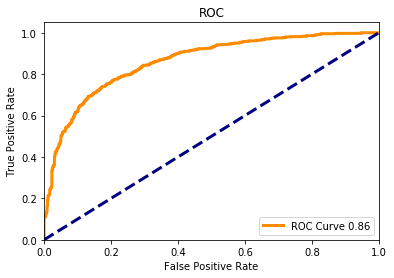

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

# Generate prediction probablities
y_test_proba = log_reg.predict_proba(X_test)

y_test_proba = y_test_proba[:,1]

# Generate False positive rate and True positive rate
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot  - Code Borrowed from Dave Yerrington Lecture
plt.figure()
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## <font color = orchid> Random Forest </font>

In [28]:
# Instantiate and fit Random Forest
rf = RandomForestClassifier(n_estimators = 150,).fit(X_train, y_train)

In [30]:
print(cross_val_score(rf, X_train, y_train, verbose = 2).mean())

print(cross_val_score(rf, X_test, y_test, verbose = 2).mean())

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 3.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV] ................................................. , total= 3.7min
[CV]  ................................................................
[CV] ................................................. , total= 3.7min
0.7263895548119365
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.2min finished
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  46.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.1s remaining:    0.0s


[CV] ................................................. , total=  41.0s
[CV]  ................................................................
[CV] ................................................. , total=  40.8s
0.722569245854462


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished


In [32]:
params_grid = [{'n_estimators': [300],
                'criterion': ['gini','entropy'],
               }]

grid = GridSearchCV(rf, params_grid, verbose = 2).fit(X_train, y_train)

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] criterion=gini, n_estimators=300 ................................
[CV] ................. criterion=gini, n_estimators=300, total= 7.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min remaining:    0.0s


[CV] criterion=gini, n_estimators=300 ................................
[CV] ................. criterion=gini, n_estimators=300, total= 7.4min
[CV] criterion=gini, n_estimators=300 ................................
[CV] ................. criterion=gini, n_estimators=300, total=60.6min
[CV] criterion=entropy, n_estimators=300 .............................
[CV] .............. criterion=entropy, n_estimators=300, total= 6.5min
[CV] criterion=entropy, n_estimators=300 .............................
[CV] .............. criterion=entropy, n_estimators=300, total=89.0min
[CV] criterion=entropy, n_estimators=300 .............................
[CV] .............. criterion=entropy, n_estimators=300, total= 8.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 180.0min finished


In [33]:
grid.best_score_

0.7346553352219075

In [34]:
grid.best_params_

{'criterion': 'entropy', 'n_estimators': 300}

In [35]:
# Generate prediction probablities
y_test_proba = grid.predict_proba(X_test)

y_test_proba = y_test_proba[:,1]

In [36]:
# Generate False positive rate and True positive rate
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

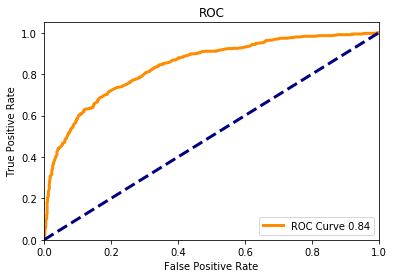

In [37]:
# Plot  - Code Borrowed from Dave Yerrington Lecture
plt.figure()
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()